In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms

import os 
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Defining the model

In [ ]:
def conv_block(in_channels, out_channels, activation=False, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels)]
    if activation: layers.append(nn.ReLU(inplace=True))
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet34(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=7, stride=1, padding=4),
            nn.BatchNorm2d(64),nn.ReLU(inplace=True))
           
        self.res1 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res2 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.res3 = nn.Sequential(conv_block(64, 64,activation=True), conv_block(64, 64))
        self.downsample1=nn.Sequential(conv_block(64, 128,pool=True)) 
        self.res4 = nn.Sequential(conv_block(64, 128,activation=True, pool=True),
                                  conv_block(128,128))
        self.res5 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res6 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res7 = nn.Sequential(conv_block(128, 128,activation=True), conv_block(128, 128))
        self.res8 = nn.Sequential(conv_block(128, 256,activation=True, pool=True),
                                  conv_block(256,256))
        self.downsample2 = nn.Sequential(conv_block(128, 256,pool=True))
        self.res9 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res10 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res11 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res12 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res13 = nn.Sequential(conv_block(256, 256,activation=True), conv_block(256, 256))
        self.res14 = nn.Sequential(conv_block(256, 512,activation=True, pool=True),
                                   conv_block(512,512))
        
        self.downsample3 = nn.Sequential(conv_block(256, 512,pool=True))
        self.res15 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512))
        self.res16 = nn.Sequential(conv_block(512, 512,activation=True), conv_block(512, 512,activation=True))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
      
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.res1(out) + out
        out = self.res2(out) + out
        out = self.res3(out) + out
        out = self.downsample1(out) +self.res4(out)
        out = self.res5(out) + out
        out = self.res6(out) + out
        out = self.res7(out) + out
        out = self.downsample2(out) +self.res8(out)
        out = self.res9(out) + out
        out = self.res10(out) + out
        out = self.res11(out) + out
        out = self.res12(out) + out
        out = self.res13(out) + out
        out = self.downsample3(out) + self.res14(out) 
        out = self.res15(out) + out
        out = self.res16(out) + out
        out = self.classifier(out)
        return out

Making list of the classes

In [ ]:
classes=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Choosing the device for the model

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
device=get_default_device()
print(device)

cpu


Loading the model

In [ ]:
model = to_device(ResNet34(3,10), device)
model.load_state_dict(torch.load('/content/cifar10-resnet34bestpth',map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
stats = ((0.4914, 0.4828, 0.4475), (0.2471, 0.2436, 0.2617))
def predict_image(path, model):
    im=Image.open(path)
    # resizing images then converting image to tensor, normalizing the tensors
    transform = transforms.Compose([transforms.Resize((44,44)),transforms.ToTensor(),transforms.Normalize(*stats,inplace=True)]) 
    img=transform(im)
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    model.eval()
    with torch.no_grad():
        yb = model(xb)
    # Pick index with highest probability
    prob=nn.Softmax(dim=1)
    yb=prob(yb)
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    print('Predicted:',classes[preds[0].item()],' with a probability of',str(round(torch.max(yb).item(), 4)*100)+'%')
    plt.imshow(im)
    plt.show()
     

Prediction of single images

Predicted: dog  with a probability of 100.0%


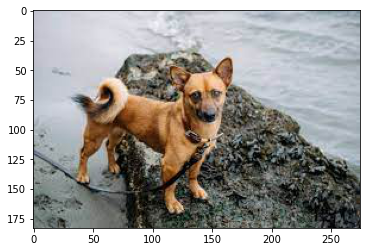

Predicted: cat  with a probability of 100.0%


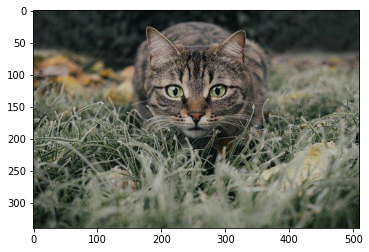

In [ ]:
predict_image('/content/dog3.jpg', model)
predict_image('/content/cat-5778777__340.jpg', model)

Prediction of images in a folder

Predicted: deer  with a probability of 100.0%


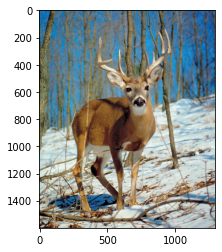

Predicted: dog  with a probability of 100.0%


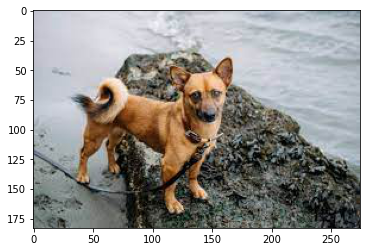

Predicted: cat  with a probability of 100.0%


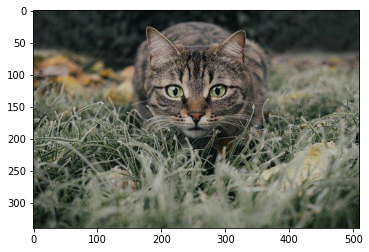

Predicted: cat  with a probability of 61.550000000000004%


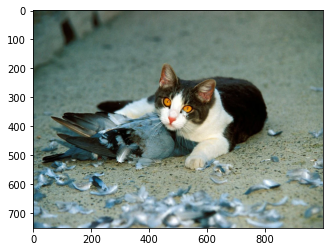

In [ ]:
# enter the path of the folder containing the images
path = '/content/'

for file in os.listdir(path):
  if file.endswith('jpg') or file.endswith('png') or file.endswith('webp') or file.endswith('jpeg'):
    predict_image('/content/'+file, model)

Prediction after uploading of files to google collab

Saving dog3.jpg to dog3 (1).jpg
Saving GettyImages-185298837.webp to GettyImages-185298837.webp
Saving golder-retriever-puppy.jpeg to golder-retriever-puppy.jpeg
Saving horse-3.jpg to horse-3.jpg
Saving horses.jpg to horses.jpg
Saving Male-white-tailed-deer.webp to Male-white-tailed-deer (1).webp
Saving Nokota_Horses_cropped.jpg to Nokota_Horses_cropped.jpg
Saving sonet-exterior-right-rear-three-quarter.jpeg to sonet-exterior-right-rear-three-quarter.jpeg
Saving Voyager_of_the_Seas_at_Port_of_Kobe.jpg to Voyager_of_the_Seas_at_Port_of_Kobe.jpg
Saving ZX7JMN3A4ZKDNMZ2A6PL3FFJTM.jpg to ZX7JMN3A4ZKDNMZ2A6PL3FFJTM.jpg
Predicted: dog  with a probability of 100.0%


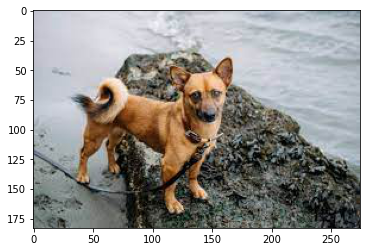

Predicted: airplane  with a probability of 100.0%


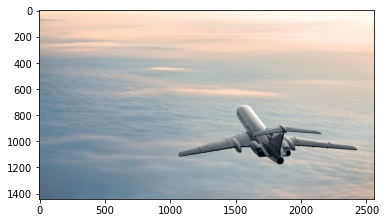

Predicted: dog  with a probability of 100.0%


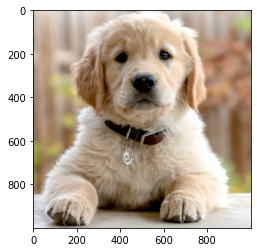

Predicted: horse  with a probability of 100.0%


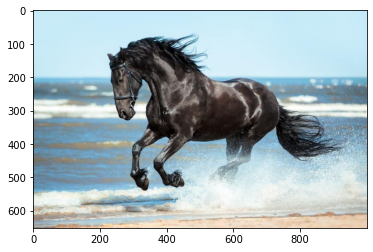

Predicted: horse  with a probability of 100.0%


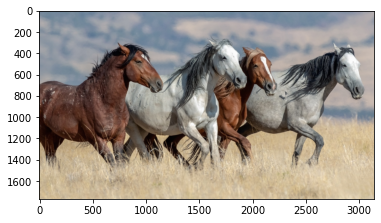

Predicted: deer  with a probability of 100.0%


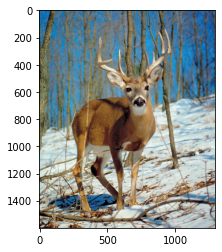

Predicted: horse  with a probability of 100.0%


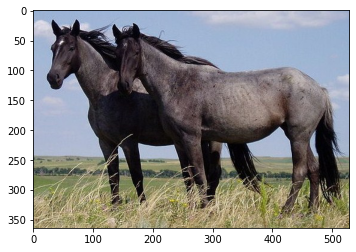

Predicted: automobile  with a probability of 99.99%


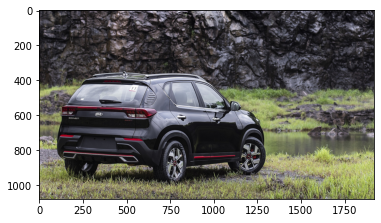

Predicted: ship  with a probability of 99.53%


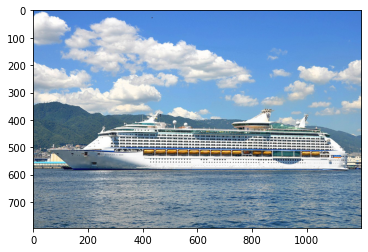

Predicted: deer  with a probability of 100.0%


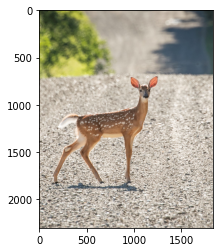

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  predict_image('/content/'+fn, model)


Saving 7A715AD8-449D-4B5A-ABA2C5D92D9B5A21_source.webp to 7A715AD8-449D-4B5A-ABA2C5D92D9B5A21_source.webp
Saving 800px-Cyanocitta_cristata_FWS_(uncropped).jpg to 800px-Cyanocitta_cristata_FWS_(uncropped).jpg
Saving 1200.jpg to 1200.jpg
Saving 1200x-1.jpg to 1200x-1.jpg
Saving 180130_White-tailed deer_lg.webp to 180130_White-tailed deer_lg.webp
Saving 200601-ecaravan-magnix-ew-451p.jpg to 200601-ecaravan-magnix-ew-451p.jpg
Saving A_chital_stag_1.jpg to A_chital_stag_1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat-5778777__340.jpg to cat-5778777__340 (1).jpg
Saving catbird.webp to catbird (1).webp
Predicted: bird  with a probability of 100.0%


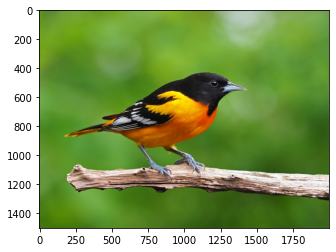

Predicted: bird  with a probability of 100.0%


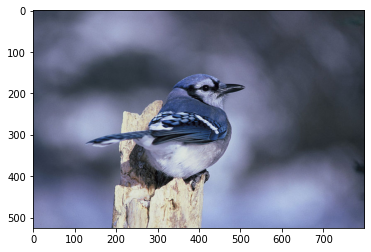

Predicted: bird  with a probability of 100.0%


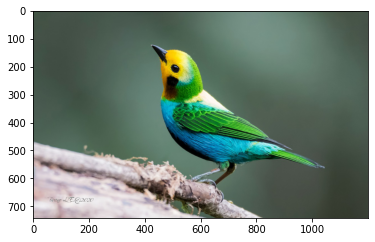

Predicted: airplane  with a probability of 100.0%


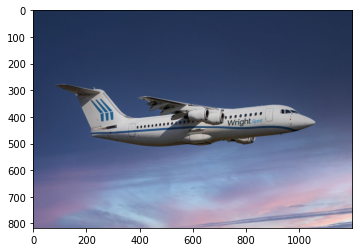

Predicted: deer  with a probability of 100.0%


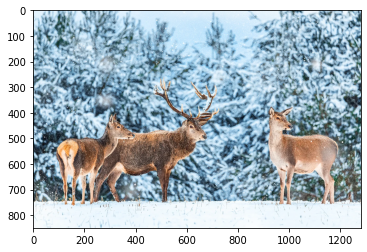

Predicted: airplane  with a probability of 100.0%


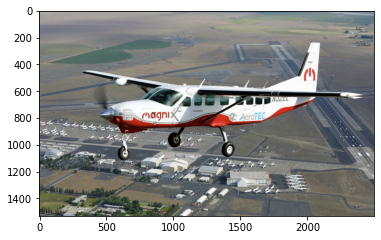

Predicted: deer  with a probability of 100.0%


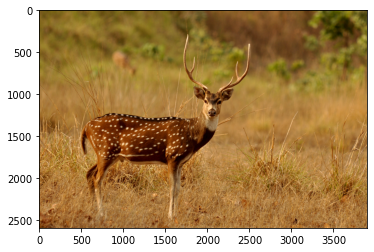

Predicted: cat  with a probability of 100.0%


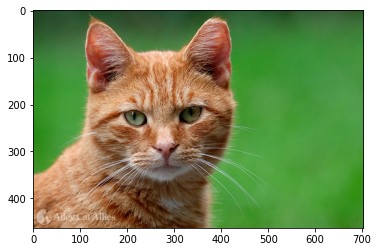

Predicted: cat  with a probability of 100.0%


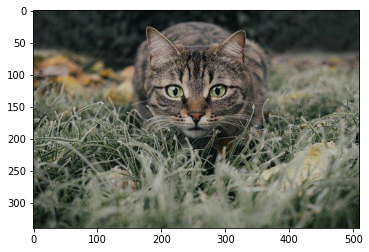

Predicted: cat  with a probability of 61.550000000000004%


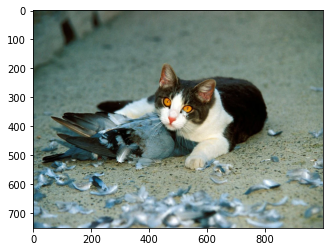

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
  predict_image('/content/'+fn, model)